In [81]:
import random
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [4]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [9]:
SEED = 1038893

fix_random(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

root = "./../data/ml-25m"

Device: cpu


In [59]:
def get_data_from_csv(file: str, nrows=None):
    if nrows:
        df = pd.read_csv(f"{root}/{file}", nrows=nrows)
    else:
        df = pd.read_csv(f"{root}/{file}")
    print(f"Loaded ml-25m data: {root}/{file}")

    return df

def get_ratings_from_csv(nrows=None):
    path = "ratings.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)

    #data.drop("timestamp", axis=1, inplace=True)
    # todo: drop user id
    #data.drop("userId", axis=1, inplace=True)

    return data

def get_tag_relevances_from_csv(nrows=None):
    path = "genome-scores.csv"

    return get_data_from_csv(path, nrows)

def get_movies_from_csv(nrows = None):
    path = 'movies.csv'

    return get_data_from_csv(path, nrows)

In [38]:
genome_scores_path = "genome-scores.csv"
ratings_path = "ratings.csv"

In [60]:
ratings = get_ratings_from_csv()
print(ratings)

Loaded ml-25m data: ./../data/ml-25m/ratings.csv
          userId  movieId  rating   timestamp
0              1      296     5.0  1147880044
1              1      306     3.5  1147868817
2              1      307     5.0  1147868828
3              1      665     5.0  1147878820
4              1      899     3.5  1147868510
...          ...      ...     ...         ...
25000090  162541    50872     4.5  1240953372
25000091  162541    55768     2.5  1240951998
25000092  162541    56176     2.0  1240950697
25000093  162541    58559     4.0  1240953434
25000094  162541    63876     5.0  1240952515

[25000095 rows x 4 columns]


In [39]:
genome_scores = get_tag_relevances_from_csv()
print(genome_scores)

Loaded ml-25m data: ./../data/ml-25m/genome-scores.csv
          movieId  tagId  relevance
0               1      1    0.02875
1               1      2    0.02375
2               1      3    0.06250
3               1      4    0.07575
4               1      5    0.14075
...           ...    ...        ...
15584443   206499   1124    0.11000
15584444   206499   1125    0.04850
15584445   206499   1126    0.01325
15584446   206499   1127    0.14025
15584447   206499   1128    0.03350

[15584448 rows x 3 columns]


In [50]:
movies = get_movies_from_csv()
print(movies)

Loaded ml-25m data: ./../data/ml-25m/movies.csv
       movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
62418   209157                           We (2018)   
62419   209159           Window of the Soul (2001)   
62420   209163                    Bad Poems (2018)   
62421   209169                 A Girl Thing (2001)   
62422   209171      Women of Devil's Island (1962)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                     

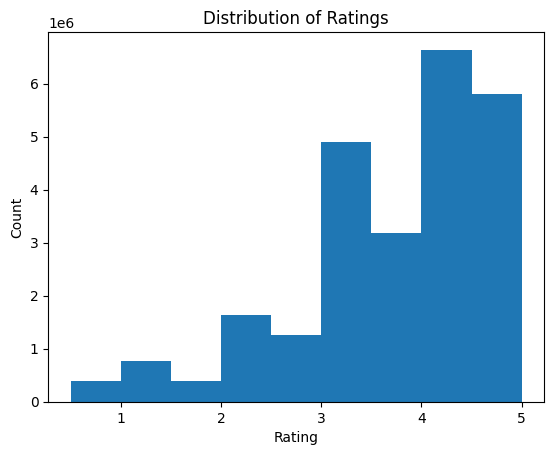

In [35]:
ratings_col = ratings['rating']

bins = np.arange(0.5, 5.5, 0.5)


plt.hist(ratings_col, bins)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()


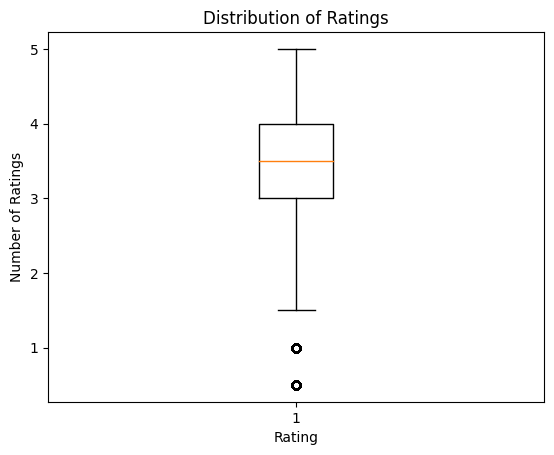

In [46]:
plt.boxplot(ratings['rating'])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()


Text(0.5, 1.0, 'Relationship Between Number of Ratings and Average Rating')

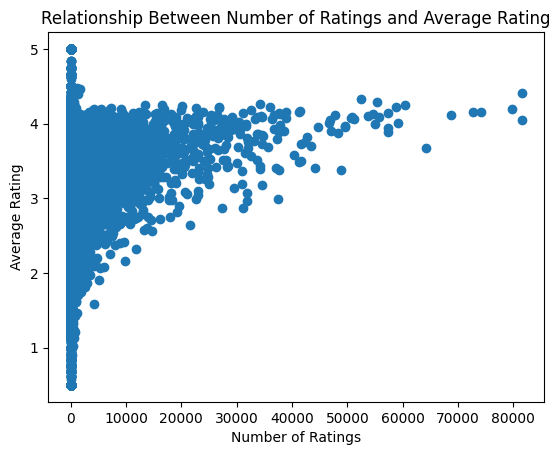

In [47]:
# Group ratings by movie ID
movie_ratings = ratings.groupby("movieId")

# Calculate the number of ratings and average rating for each movie
num_ratings = movie_ratings.size()
avg_rating = movie_ratings.mean()["rating"]

# Create scatter plot
plt.scatter(num_ratings, avg_rating)

# Add labels and title
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.title("Relationship Between Number of Ratings and Average Rating")


Text(0.5, 1.0, 'Distribution of Ratings Across Different Genres')

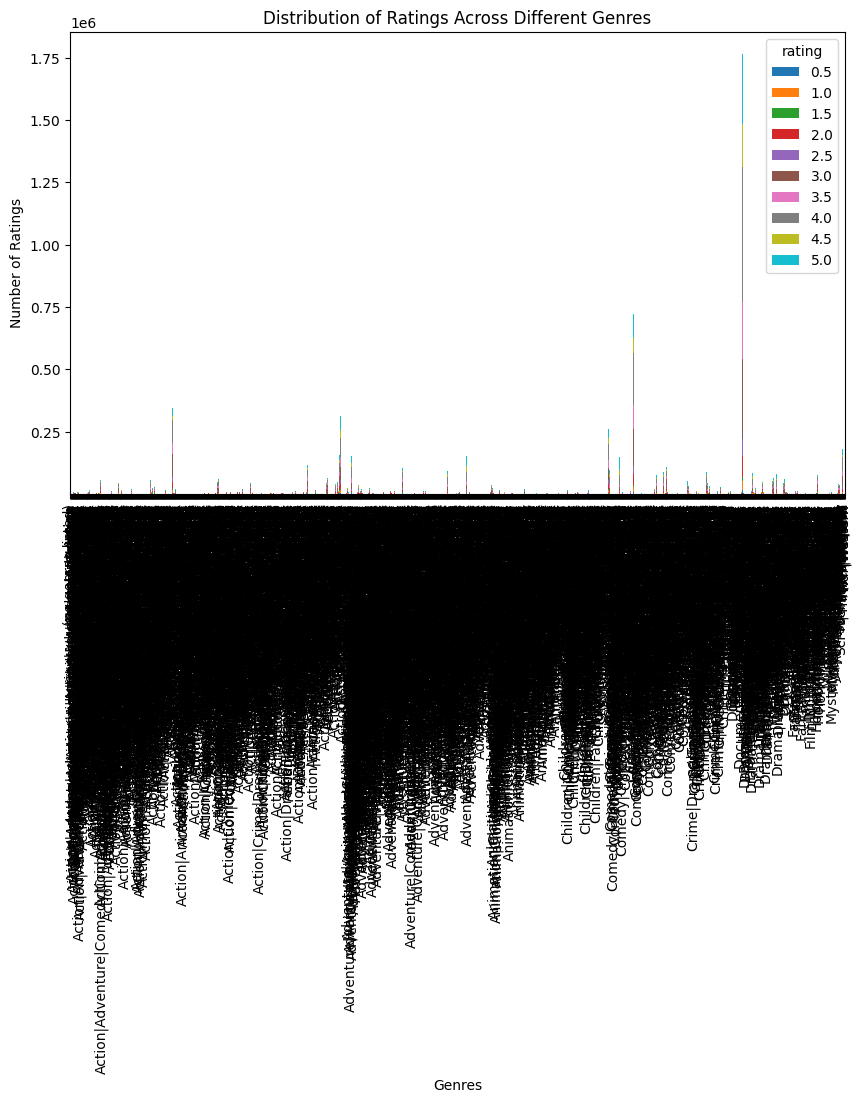

In [51]:
movie_ratings = pd.merge(movies, ratings, on='movieId')

# Next, let's group the data by genre and rating
genre_rating_grouped = movie_ratings.groupby(['genres', 'rating']).size().reset_index(name='counts')

# Create a pivot table to reshape the data
pivot_table = genre_rating_grouped.pivot(index='genres', columns='rating', values='counts').fillna(0)

# Create a stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and titles
plt.xlabel('Genres')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Ratings Across Different Genres')


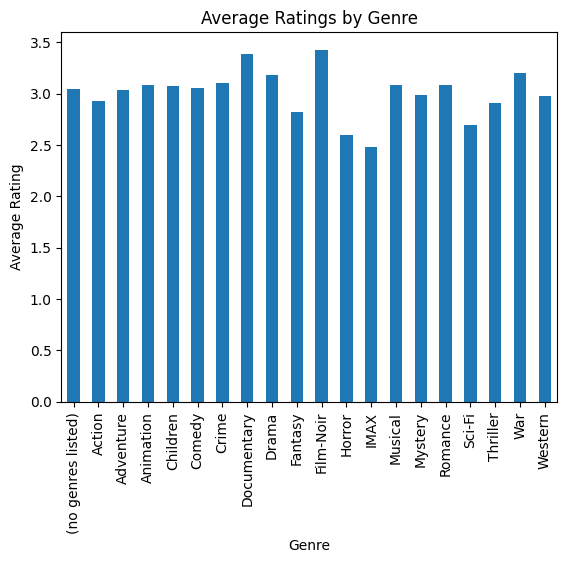

In [53]:
movies_with_ratings = movies.set_index('movieId').join(ratings.groupby('movieId')['rating'].mean())

# Split genres column into multiple columns
genres = movies_with_ratings['genres'].str.split('|', expand=True)
genres.columns = [f"genre_{i+1}" for i in genres.columns]

# Concatenate genres with movies_with_ratings
movies_with_genres = pd.concat([movies_with_ratings, genres], axis=1)

# Compute average ratings for each genre
genre_ratings = movies_with_genres.groupby('genre_1').agg({'rating': 'mean'})

# Plot stacked bar chart of average ratings by genre
genre_ratings.plot(kind='bar', stacked=True, legend=False)
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Ratings by Genre')
plt.show()

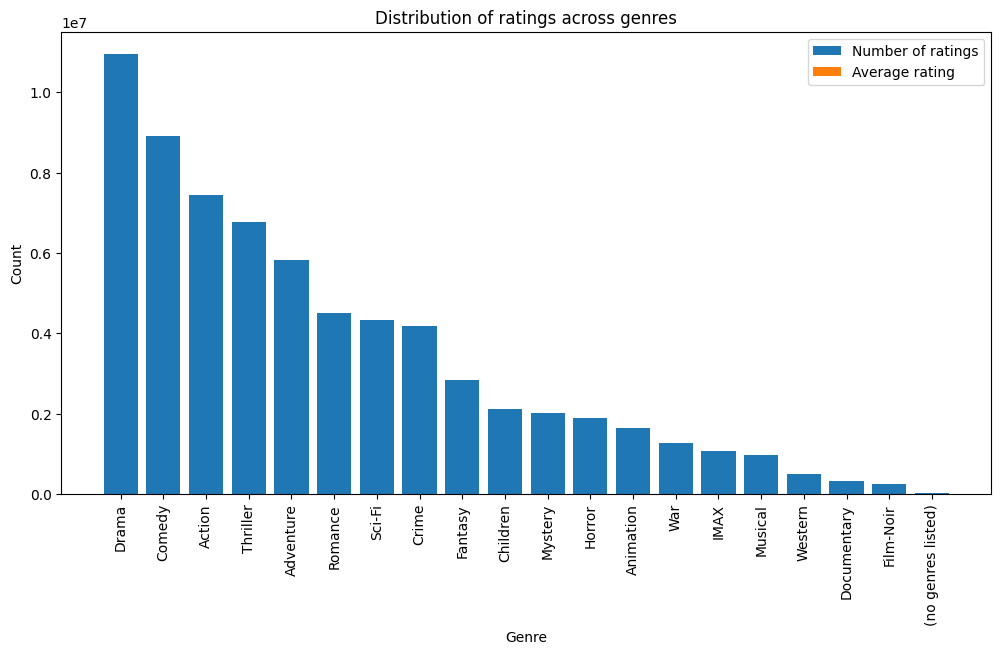

In [54]:
# Extract the year from the title column in the movies dataset
movies['year'] = movies['title'].str.extract('\((\d{4})\)', expand=False)

# Split the genres column in the movies dataset and create a new row for each genre
genres = movies['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).rename('genre')

# Join the genres information with the movies dataset
movies_with_genres = movies.drop('genres', axis=1).join(genres, how='inner')

# Join the ratings dataset with the movies_with_genres dataset
ratings_with_genres = ratings.merge(movies_with_genres, on='movieId', how='inner')

# Calculate the average rating and number of ratings for each genre
genre_stats = ratings_with_genres.groupby('genre').agg({'rating': ['mean', 'count']})

# Flatten the multi-level column names
genre_stats.columns = ['_'.join(col).strip() for col in genre_stats.columns.values]

# Reset the index to get the genre column back
genre_stats = genre_stats.reset_index()

# Sort the genres by the number of ratings
genre_stats = genre_stats.sort_values(by='rating_count', ascending=False)

# Create a stacked bar chart to show the distribution of the number of ratings and the average rating across different genres
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(genre_stats['genre'], genre_stats['rating_count'], label='Number of ratings')
ax.bar(genre_stats['genre'], genre_stats['rating_mean'], label='Average rating')
ax.set_xlabel('Genre')
ax.set_ylabel('Count')
ax.set_title('Distribution of ratings across genres')
ax.legend()
plt.xticks(rotation=90)
plt.show()


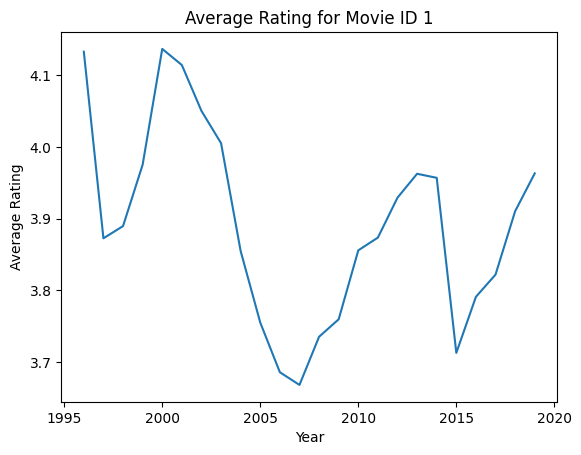

In [61]:
movie_id = 1
movie_ratings = ratings[ratings['movieId'] == movie_id]

# Calculate the average rating for the movie over time
avg_ratings_by_year = movie_ratings.groupby(movie_ratings['timestamp'].apply(lambda x: pd.Timestamp(x, unit='s').year))['rating'].mean()

# Create a line chart to show how the average rating changes over time
plt.plot(avg_ratings_by_year.index, avg_ratings_by_year.values)
plt.title(f"Average Rating for Movie ID {movie_id}")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.show()

In [84]:
# Merge the movies and ratings dataframes
movie_ratings = pd.merge(movies, ratings, on='movieId')



In [85]:
# Convert the 'timestamp' column to a datetime object and extract the year
movie_ratings['year'] = pd.to_datetime(movie_ratings['timestamp'], unit='s').dt.year

# Compute the average rating for each movie in each year
avg_ratings = movie_ratings.groupby(['year', 'movieId'])['rating'].mean().reset_index()

# Create a streamgraph of the average rating of movies over time, grouped by genre
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='rating', hue='genres', data=pd.merge(avg_ratings, movies[['movieId', 'genres']], on='movieId'))
plt.title('Average rating of movies over time by genre')
plt.xlabel('Year')
plt.ylabel('Average rating')
plt.show()

KeyboardInterrupt: 